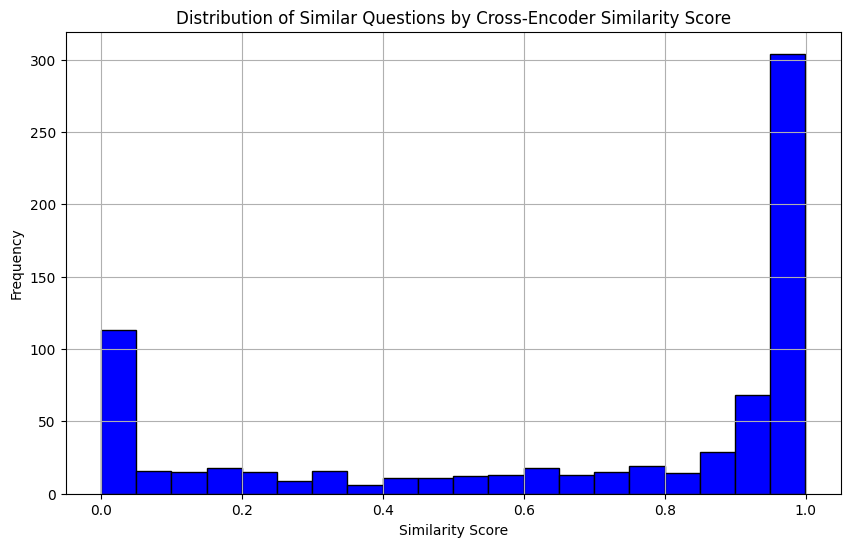

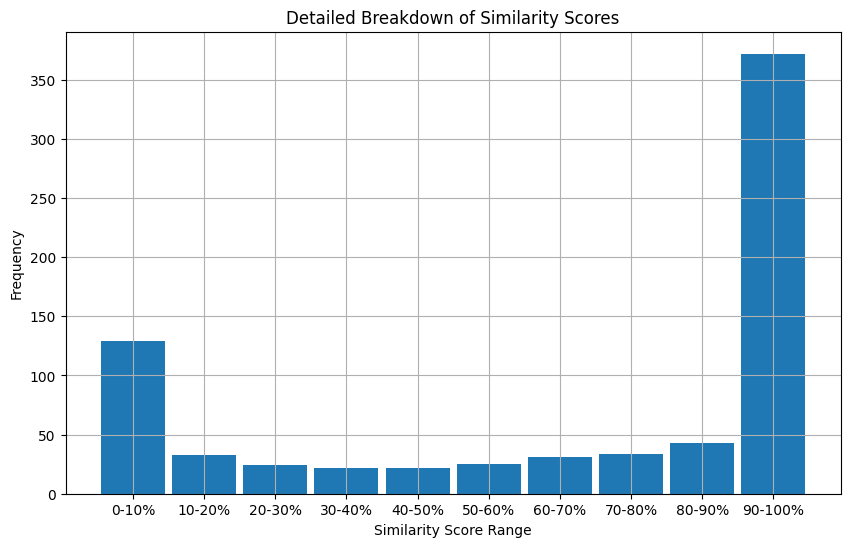

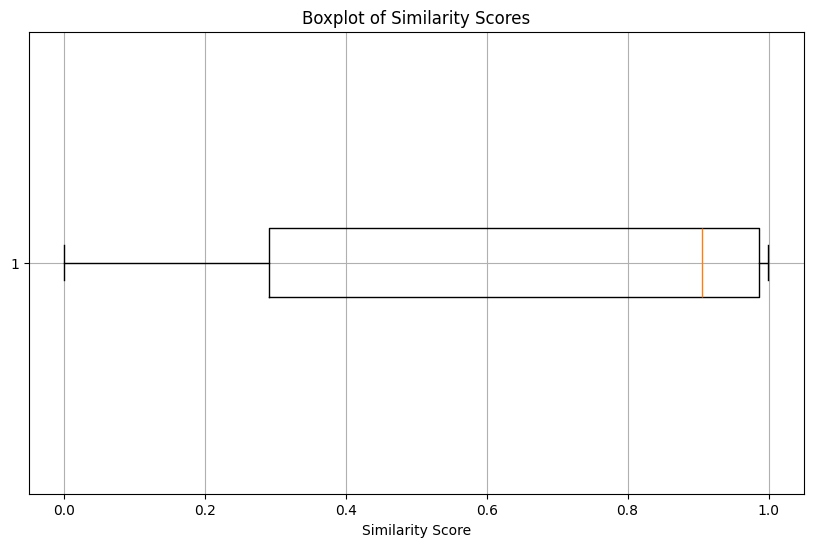

Mean Similarity Score: 0.666835553613598
Median Similarity Score: 0.9055554866790771
Standard Deviation: 0.38399318466332755


In [3]:
import os
import json
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

class CrossEncoderSimilarityScorer:
    def __init__(self, model_name: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)

    def score(self, ground_truth: str, answer: str) -> float:
        inputs = self.tokenizer(ground_truth, answer, return_tensors='pt', truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)

        logits = outputs.logits
        similarity_score = torch.sigmoid(logits).item()

        return similarity_score

def read_json_files(base_dir):
    data = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('data.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    json_data = json.load(f)
                    data.append(json_data)
    return data

def calculate_similarity(data, scorer):
    similarity_scores = []

    for dataset in data:
        for category in dataset:
            for question_data in dataset[category]:
                original_question = question_data['question']
                for similar_question in question_data['similarQuestions']:
                    similarity_score = scorer.score(original_question, similar_question['question'])
                    similarity_scores.append(similarity_score)
    
    return similarity_scores

def plot_similarity_distribution(similarity_scores):
    plt.figure(figsize=(10, 6))
    plt.hist(similarity_scores, bins=20, color='blue', edgecolor='black')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Similar Questions by Cross-Encoder Similarity Score')
    plt.grid(True)
    plt.show()

def plot_detailed_breakdown(similarity_scores):
    bins = [i/10 for i in range(11)]
    counts, _ = np.histogram(similarity_scores, bins=bins)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(counts)), counts, width=0.9, tick_label=[f'{i*10}-{(i+1)*10}%' for i in range(10)])
    plt.xlabel('Similarity Score Range')
    plt.ylabel('Frequency')
    plt.title('Detailed Breakdown of Similarity Scores')
    plt.grid(True)
    plt.show()

def plot_boxplot(similarity_scores):
    plt.figure(figsize=(10, 6))
    plt.boxplot(similarity_scores, vert=False)
    plt.xlabel('Similarity Score')
    plt.title('Boxplot of Similarity Scores')
    plt.grid(True)
    plt.show()

def calculate_statistics(similarity_scores):
    mean_score = np.mean(similarity_scores)
    median_score = np.median(similarity_scores)
    std_dev = np.std(similarity_scores)
    
    print(f'Mean Similarity Score: {mean_score}')
    print(f'Median Similarity Score: {median_score}')
    print(f'Standard Deviation: {std_dev}')

if __name__ == "__main__":
    base_dir = 'datasets_similar'
    data = read_json_files(base_dir)
    scorer = CrossEncoderSimilarityScorer()
    similarity_scores = calculate_similarity(data, scorer)
    
    plot_similarity_distribution(similarity_scores)
    plot_detailed_breakdown(similarity_scores)
    plot_boxplot(similarity_scores)
    calculate_statistics(similarity_scores)


In [5]:
import os
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

class CrossEncoderSimilarityScorer:
    def __init__(self, model_name: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)

    def score(self, ground_truth: str, answer: str) -> float:
        inputs = self.tokenizer(ground_truth, answer, return_tensors='pt', truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)

        logits = outputs.logits
        similarity_score = torch.sigmoid(logits).item()

        return similarity_score

def read_json_files(base_dir):
    data = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('data.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    json_data = json.load(f)
                    data.append(json_data)
    return data

def calculate_similarity(data, scorer):
    similarity_scores = []
    low_similarity_examples = []
    high_similarity_examples = []

    for dataset in data:
        for category in dataset:
            for question_data in dataset[category]:
                original_question = question_data['question']
                for similar_question in question_data['similarQuestions']:
                    similarity_score = scorer.score(original_question, similar_question['question'])
                    similarity_scores.append(similarity_score)
                    if similarity_score < 0.1 and len(low_similarity_examples) < 3:
                        low_similarity_examples.append((original_question, similar_question['question'], similarity_score))
                    if similarity_score > 0.9 and len(high_similarity_examples) < 3:
                        high_similarity_examples.append((original_question, similar_question['question'], similarity_score))
    
    return similarity_scores, low_similarity_examples, high_similarity_examples

if __name__ == "__main__":
    base_dir = 'datasets_similar'
    data = read_json_files(base_dir)
    scorer = CrossEncoderSimilarityScorer()
    similarity_scores, low_similarity_examples, high_similarity_examples = calculate_similarity(data, scorer)
    
    print("Low Similarity Examples (< 10%):")
    for original, similar, score in low_similarity_examples:
        print(f"Original: {original}")
        print(f"Similar: {similar}")
        print(f"Score: {score}\n")
    
    print("High Similarity Examples (> 90%):")
    for original, similar, score in high_similarity_examples:
        print(f"Original: {original}")
        print(f"Similar: {similar}")
        print(f"Score: {score}\n")


Low Similarity Examples (< 10%):
Original: What is the significance of a B-tree's order in database indexing, is it commonplace in commercial database systems?
Similar: How does the order of a B-tree affect its performance?
Score: 0.07028614729642868

Original: What are some common issues with developing applications without a database?
Similar: Why is using files instead of databases problematic?
Score: 0.003462623804807663

Original: What is a deadlock in the context of lock-based protocols?
Similar: Why do deadlocks happen in databases?
Score: 0.03831719607114792

High Similarity Examples (> 90%):
Original: Can you explain the differences between volatile and non-volatile memory?
Similar: How does volatile memory differ from non-volatile memory?
Score: 0.9970467686653137

Original: What is the most common RAID level used in commercial database systems?
Similar: Why is RAID 5 preferred in commercial databases?
Score: 0.9682673215866089

Original: What is the significance of a B-tree'

In [1]:
import os
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

class CrossEncoderSimilarityScorer:
    def __init__(self, model_name: str = 'cross-encoder/ms-marco-MiniLM-L-6-v2'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)

    def score(self, ground_truth: str, answer: str) -> float:
        inputs = self.tokenizer(ground_truth, answer, return_tensors='pt', truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)

        logits = outputs.logits
        similarity_score = torch.sigmoid(logits).item()

        return similarity_score

def read_json_files(base_dir):
    data = []
    file_paths = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('data.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    json_data = json.load(f)
                    data.append(json_data)
                    file_paths.append(file_path)
    return data, file_paths

def update_similarity_levels(data, scorer):
    for dataset in data:
        for category in dataset:
            for question_data in dataset[category]:
                original_question = question_data['question']
                for similar_question in question_data['similarQuestions']:
                    similarity_score = scorer.score(original_question, similar_question['question'])
                    similar_question['similarityLevel'] = f"{similarity_score:.2f}"
    return data

def write_json_files(data, file_paths):
    for json_data, file_path in zip(data, file_paths):
        with open(file_path, 'w') as f:
            json.dump(json_data, f, indent=4)

if __name__ == "__main__":
    base_dir = 'datasets_similar'
    data, file_paths = read_json_files(base_dir)
    scorer = CrossEncoderSimilarityScorer()
    updated_data = update_similarity_levels(data, scorer)
    write_json_files(updated_data, file_paths)


/Users/kevin/officeHours/chatbotRelated/chatbot/test/RAGtesting/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


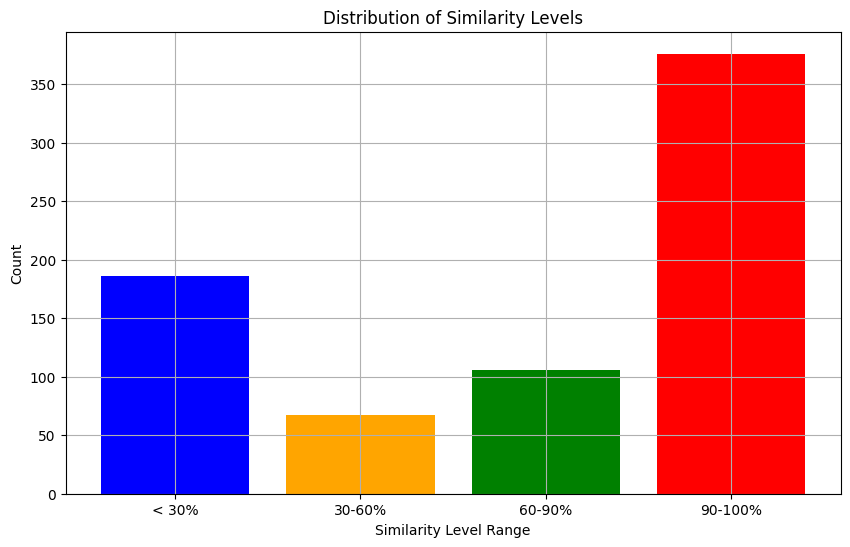

In [9]:
import os
import json
import matplotlib.pyplot as plt

def read_json_files(base_dir):
    data = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('data.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    json_data = json.load(f)
                    data.append(json_data)
    return data

def categorize_similarity_levels(data):
    similarity_categories = {'< 30%': 0, '30-60%': 0, '60-90%': 0, '90-100%': 0}

    for dataset in data:
        for category in dataset:
            for question_data in dataset[category]:
                for similar_question in question_data['similarQuestions']:
                    similarity_score = float(similar_question['similarityLevel'])
                    if similarity_score < 0.3:
                        similarity_categories['< 30%'] += 1
                    elif similarity_score < 0.6:
                        similarity_categories['30-60%'] += 1
                    elif similarity_score < 0.9:
                        similarity_categories['60-90%'] += 1
                    else:
                        similarity_categories['90-100%'] += 1
    
    return similarity_categories

def plot_similarity_histogram(similarity_categories):
    categories = list(similarity_categories.keys())
    counts = list(similarity_categories.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Similarity Level Range')
    plt.ylabel('Count')
    plt.title('Distribution of Similarity Levels')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    base_dir = 'datasets_similar'
    data = read_json_files(base_dir)
    similarity_categories = categorize_similarity_levels(data)
    plot_similarity_histogram(similarity_categories)
